In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# import pickle as pk
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
# from torch.distributions import MultivariateNormal
# from torch.distributions import Normal
root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from nf.combined_models_wmaskSumGauss import COMBINED_Model
# from nf.combined_models_classification import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep_cosmo import *
# from tqdm import tqdm
# import pyyaml
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml
import pickle as pk
# autoreload modules
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib

import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline



%load_ext Cython


        
        
        



In [3]:
isim_fid = 0
snapnum = 3
mass_type = 'rockstar_200c'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
snapdir = snap_dir_base + '/' + str(isim_fid)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
if mass_type == 'rockstar_vir':
    index_M = header.index('Mvir')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
if mass_type == 'rockstar_200c':
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

Mmin_cut = 1e13
lgMass_truth = np.log10(mass_truth)
indsel = np.where(mass_truth > Mmin_cut)[0]
# print(grid, len(indsel), len(mass_truth), np.amin(lgMass_truth), np.log10(Mmin_cut))
pos_h_truth = pos_h_truth[indsel]
lgMass_truth = lgMass_truth[indsel]


/tmp/ipykernel_3046184/3793945164.py:20: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth)


In [4]:
# pos_h_truth.shape, mass_truth.shape
import numpy as np
import readgadget
snapshot = f'/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/fiducial_HR/{isim_fid}/snapdir_{snapnum:03d}/snap_{snapnum:03d}'
ptype = [1] #DM is 1, neutrinos is [2]
pos   = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
vel   = readgadget.read_block(snapshot, "VEL ", ptype)     #peculiar velocities in km/s
ids   = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0


In [5]:
npart_test = 128**3
downsample = int(len(pos)/npart_test)
# select a random subset of particles:
np.random.seed(0)
ind = np.random.choice(len(pos), npart_test, replace=False)
pos_m_truth = pos[ind]
vel_m_truth = vel[ind]
ids_m_truth = ids[ind]



In [6]:
BoxSize = 1000.
grid = 32
nMax_m = 32
Npart = np.float32(np.zeros((grid, grid, grid)))
MASL.NGP(np.float32(pos_m_truth), Npart, BoxSize)



# Distribution of number of dark matter particles in each voxel. Voxel is of size ~30Mpc/h


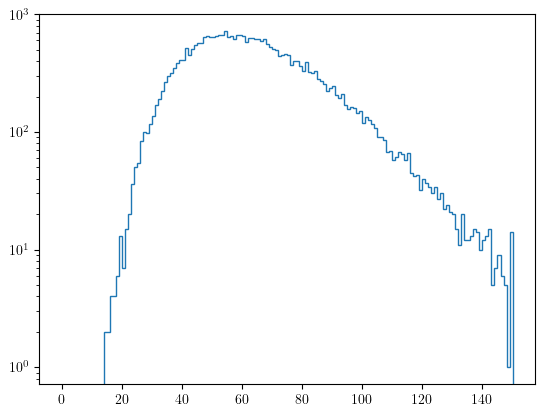

In [7]:
# np.amax(Nhalos)
pl.figure()
_ = pl.hist(Npart.flatten(), bins=150, range=(0, 150), histtype='step')
pl.yscale('log')




In [8]:
%%cython
cimport numpy as np
cpdef void NGP_xyzM(np.float32_t[:,:] pos, np.float32_t[:] logM, np.float32_t[:,:,:,:,:] gridM, float BoxSize):

    cdef int axis,dims,coord,nMmax,jM
    cdef long i,particles
    cdef float inv_cell_size
    cdef float pos0, pos1, pos2
    cdef int index[3]
    cdef int tobreak

    # find number of particles, the inverse of the cell size and dims
    particles = pos.shape[0];  coord = pos.shape[1];  dims = gridM.shape[0]; nMmax = gridM.shape[3]
    inv_cell_size = dims/BoxSize

    # when computing things in 2D, use the index[2]=0 plane
    for i in range(3):  index[i] = 0

    # do a loop over all particles
    for i in range(particles):
        for axis in range(coord):
            index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
            if axis == 0:
                pos0 = pos[i,axis] - index[axis]*BoxSize/dims
            if axis == 1:
                pos1 = pos[i,axis] - index[axis]*BoxSize/dims
            if axis == 2:
                pos2 = pos[i,axis] - index[axis]*BoxSize/dims
            index[axis] = (index[axis]+dims)%dims
        for jM in range(nMmax):
            if (gridM[index[0],index[1],index[2], jM, 0] == 0) and (gridM[index[0],index[1],index[2], jM, 1] == 0) and (gridM[index[0],index[1],index[2], jM, 2] == 0) and (gridM[index[0],index[1],index[2], jM, 3] == 0):
                gridM[index[0],index[1],index[2], jM, 0] = pos0
                gridM[index[0],index[1],index[2], jM, 1] = pos1
                gridM[index[0],index[1],index[2], jM, 2] = pos2
                gridM[index[0],index[1],index[2], jM, 3] = logM[i]
                break
            else:
                pass


            

In file included from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /dev/shm/.cache-spandey/ipython/cython/_cython_magic_8e92a03fea1377cb7ef68053c6ef25c2.c:775:
/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
/dev/shm/.cache-spandey/ipython/cython/_cython_magic_8e92a03fea1377cb7ef68053c6ef25c2.c: In function '__pyx_pw_46_cython_magic_8e92a03fea1

In [9]:
# elif grid == 128:
BoxSize = 1000.
grid = 32
nMax_h = 32
dfhalo_ngp_wxyzM = np.float32(np.zeros((grid, grid, grid, nMax_h, 4)))
NGP_xyzM(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wxyzM, BoxSize)


In [10]:
Nhalos_truth = np.float32(np.zeros((grid, grid, grid)))
MASL.NGP(np.float32(pos_h_truth), Nhalos_truth, BoxSize)


2

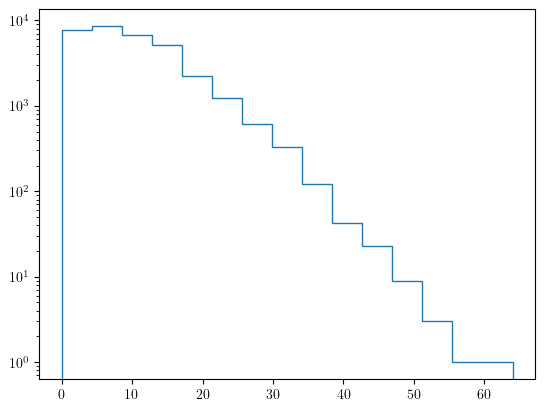

In [11]:
# np.amax(Nhalos)
pl.figure()
_ = pl.hist(Nhalos_truth.flatten(), bins=15, range=(0, 64), histtype='step')
pl.yscale('log')

2


In [12]:
# sort dfhalo_ngp_wxyzM according to the last index which corresponds to halo mass. Do the sorting in decreasing order:
# dfhalo_ngp_wxyzM = dfhalo_ngp_wxyzM[np.argsort(dfhalo_ngp_wxyzM[:,:,:,:,-1], axis=-1)[::-1]]
# np.argsort(dfhalo_ngp_wmass, axis=-1)
M_halos_argsort = np.flip(np.argsort(dfhalo_ngp_wxyzM[:,:,:,:,3], axis=-1), axis=-1)
xmin = BoxSize/grid/2
lgMin = np.log10(Mmin_cut)
lgMax = 15.5
# M_halos_argsort
# M_halos_argsort.shape, dfhalo_ngp_wxyz.shape
# dfhalo_ngp_xyz_sorted = dfhalo_ngp_wxyz[M_halos_argsort]
dfhalo_ngp_xyzM_sorted_scaled = np.zeros_like(dfhalo_ngp_wxyzM)
for i1 in range(grid):
    for i2 in range(grid):
        for i3 in range(grid):
            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 0] = dfhalo_ngp_wxyzM[i1, i2, i3, M_halos_argsort[i1, i2, i3], 0]
            indpos_x = np.where(dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 0] != 0.0)[0]
            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_x, 0] = (dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_x, 0] + xmin)/(2*xmin)

            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 1] = dfhalo_ngp_wxyzM[i1, i2, i3, M_halos_argsort[i1, i2, i3], 1]
            indpos_y = np.where(dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 1] != 0.0)[0]
            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_y, 1] = (dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_y, 1] + xmin)/(2*xmin)

            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 2] = dfhalo_ngp_wxyzM[i1, i2, i3, M_halos_argsort[i1, i2, i3], 2]
            indpos_z = np.where(dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 2] != 0.0)[0]
            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_z, 2] = (dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_z, 2] + xmin)/(2*xmin)

            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 3] = dfhalo_ngp_wxyzM[i1, i2, i3, M_halos_argsort[i1, i2, i3], 3]
            indpos_M = np.where(dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 3] != 0.0)[0]
            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_M, 3] = (dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_M, 3] - lgMin)/(lgMax - lgMin)





In [13]:
# M_halos_argsort



In [14]:
indzeros = np.where(dfhalo_ngp_xyzM_sorted_scaled == 0.0)
dfhalo_ngp_xyzM_sorted_scaled[indzeros] = -1.0



In [15]:
# np.amin(dfhalo_ngp_xyzM_sorted_scaled), np.amax(dfhalo_ngp_xyzM_sorted_scaled)
nvocab = 256
bins_digitize = np.linspace(-1e-3, 1, nvocab)
# bins_digitize.insert(0, -1)
bins_digitize = np.insert(bins_digitize, 0, -1)
# bins_digitize
dfhalo_ngp_xyzM_sorted_scaled_digitized = np.digitize(dfhalo_ngp_xyzM_sorted_scaled, bins_digitize)


In [16]:
dfhalo_ngp_xyzM_sorted_scaled.shape


(32, 32, 32, 32, 4)

In [19]:
# dfhalo_ngp_xyzM_sorted_scaled[0,0,0,:,0]
# start_token = 0
# pad_token = 1
# end_token = nvocab + 1
# space_token = nvocab + 2
max_sentence_length = nMax_h*4
dfhalo_ngp_xyzM_nontokenized = np.zeros((grid, grid, grid, max_sentence_length), dtype=np.float32)

# dfhalo_ngp_xyzM_nontokenized[..., 0] = start_token
# for jh in range(nMax_h):
jh = 0
while jh < 4*nMax_h:
    # if dfhalo_ngp_xyzM_sorted_scaled_digitized[..., jh, 0] > 1:
    dfhalo_ngp_xyzM_nontokenized[..., jh + 0] = dfhalo_ngp_xyzM_sorted_scaled[..., jh//5, 3]
    dfhalo_ngp_xyzM_nontokenized[..., jh + 1] = dfhalo_ngp_xyzM_sorted_scaled[..., jh//5, 0]
    dfhalo_ngp_xyzM_nontokenized[..., jh + 2] = dfhalo_ngp_xyzM_sorted_scaled[..., jh//5, 1]
    dfhalo_ngp_xyzM_nontokenized[..., jh + 3] = dfhalo_ngp_xyzM_sorted_scaled[..., jh//5, 2]
    # if jh//5 < nMax_h - 1:
    #     dfhalo_ngp_xyzM_tokenized[..., jh + 4] = space_token
    # else:
    #     dfhalo_ngp_xyzM_tokenized[..., 1 + nMax_h*4] = end_token
    jh += 4




In [25]:
# for ji in range(len(dfhalo_ngp_xyzM_nontokenized[0,12,0,:])//4):
    # print(dfhalo_ngp_xyzM_nontokenized[0,12,0,ji:ji+4])
dfhalo_ngp_xyzM_nontokenized[0,12,0,:]


array([ 0.28291208,  0.7189693 ,  0.17271973,  0.7870349 ,  0.28291208,
        0.7189693 ,  0.17271973,  0.7870349 ,  0.22501716,  0.43239647,
        0.16191211,  0.18850781,  0.21825142,  0.8414768 ,  0.1848584 ,
        0.11461328,  0.1920143 ,  0.67684734,  0.35814747,  0.6713965 ,
        0.17149353,  0.30295703,  0.4099707 ,  0.25056055,  0.17149353,
        0.30295703,  0.4099707 ,  0.25056055,  0.16989402,  0.8034755 ,
        0.20751855,  0.9040032 ,  0.1414051 ,  0.75048804,  0.35052246,
        0.7213424 ,  0.13757591,  0.4939746 ,  0.3518789 ,  0.5908697 ,
        0.1309925 ,  0.78477085,  0.8358555 ,  0.9968733 ,  0.1309925 ,
        0.78477085,  0.8358555 ,  0.9968733 ,  0.12964706,  0.5347504 ,
        0.2820918 ,  0.23718163,  0.11776008,  0.1533457 ,  0.31173047,
        0.6810259 ,  0.11036415,  0.49513087,  0.8785205 ,  0.7313533 ,
        0.09620972,  0.24171485,  0.22868554,  0.7440368 ,  0.09620972,
        0.24171485,  0.22868554,  0.7440368 ,  0.09620972,  0.28

In [13]:
# dfhalo_ngp_wxyzM[0,12,0,:,-1]
np.amax(dfhalo_ngp_xyzM_sorted_scaled_digitized)


256

In [14]:
# dfhalo_ngp_xyzM_sorted_scaled_digitized
# dfhalo_ngp_xyzM_sorted_scaled_digitized[0,12,0,:,-1]
start_token = 0
pad_token = 1
end_token = nvocab + 1
space_token = nvocab + 2
max_sentence_length = 1 + nMax_h*4 + 1 + (nMax_h-1)
dfhalo_ngp_xyzM_tokenized = np.zeros((grid, grid, grid, max_sentence_length), dtype=np.int32) + end_token

dfhalo_ngp_xyzM_tokenized[..., 0] = start_token
# for jh in range(nMax_h):
jh = 1
while jh < 5*nMax_h:
    # if dfhalo_ngp_xyzM_sorted_scaled_digitized[..., jh, 0] > 1:
    dfhalo_ngp_xyzM_tokenized[..., jh + 0] = dfhalo_ngp_xyzM_sorted_scaled_digitized[..., jh//5, 3]
    dfhalo_ngp_xyzM_tokenized[..., jh + 1] = dfhalo_ngp_xyzM_sorted_scaled_digitized[..., jh//5, 0]
    dfhalo_ngp_xyzM_tokenized[..., jh + 2] = dfhalo_ngp_xyzM_sorted_scaled_digitized[..., jh//5, 1]
    dfhalo_ngp_xyzM_tokenized[..., jh + 3] = dfhalo_ngp_xyzM_sorted_scaled_digitized[..., jh//5, 2]
    if jh//5 < nMax_h - 1:
        dfhalo_ngp_xyzM_tokenized[..., jh + 4] = space_token
    # else:
    #     dfhalo_ngp_xyzM_tokenized[..., 1 + nMax_h*4] = end_token
    jh += 5




In [15]:
# dfhalo_ngp_xyzM_tokenized[0,0,0,:]
dfhalo_ngp_xyzM_tokenized_padded_ended = np.copy(dfhalo_ngp_xyzM_tokenized)
for i1 in range(grid):
    for i2 in range(grid):
        for i3 in range(grid):
            ind1 = np.where(dfhalo_ngp_xyzM_tokenized[i1, i2, i3,:] == 1)[0]
            try:
                ind1 = ind1[0]
                dfhalo_ngp_xyzM_tokenized_padded_ended[i1, i2, i3, ind1-1] = end_token
                dfhalo_ngp_xyzM_tokenized_padded_ended[i1, i2, i3, ind1:] = pad_token
            except:
                dfhalo_ngp_xyzM_tokenized_padded_ended[i1, i2, i3, ind1-1] = end_token
                # dfhalo_ngp_xyzM_tokenized_padded_ended[i1, i2, i3, ind1:] = pad_token




In [16]:
dfhalo_ngp_xyzM_tokenized_padded_ended[0,12,0,:]
# np.where(dfhalo_ngp_xyzM_tokenized[0,0,0,:] == 1)[0]
# emb = nn.Embedding(5,5)
# emb(torch.Tensor([0,1,2,3,4]).long())


array([  0,  74, 185,  46, 202, 258,  59, 112,  43,  50, 258,  57, 216,
        49,  31, 258,  51, 174,  93, 173, 258,  45,  79, 106,  66, 258,
        45, 206,  55, 232, 258,  38, 193,  91, 186, 258,  37, 128,  91,
       152, 258,  35, 202, 215, 256, 258,  35, 138,  74,  62, 258,  32,
        41,  81, 175, 258,  30, 128, 226, 188, 258,  26,  63,  60, 191,
       258,  26,  75,  50, 220, 258,  21, 137,  54,  46, 258,  15, 194,
        56,  31, 258,   8, 212,   6, 195, 258,   3, 156,  56,  54, 257,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1], dtype=int32)

In [17]:
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed = np.reshape(dfhalo_ngp_xyzM_tokenized_padded_ended, (grid*grid*grid, max_sentence_length))
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed.shape


(32768, 161)

In [18]:
# n1_all = np.zeros(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed.shape[0])
# for ji in range(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed.shape[0]):
#     n1 = len(np.where(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed[ji,:] != 1)[0])
#     n1_all[ji] = n1

# ind_to_remove = np.where(n1_all == 1)[0]
# dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed = np.delete(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed, ind_to_remove, axis=0)



In [19]:
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed.shape


(32768, 161)

In [20]:
n = int(0.9*len(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed)) # first 90% will be train, rest val
train_data = dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed[:n]
val_data = dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed[n:]


In [21]:
# mask_batch_reshape.shape
# mask_batch_reshape.transpose(1, 2)
# mask_batch_reshape.shape
# x_train.shape, y_train.shape
# train_data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x = torch.tensor(train_data[:, :-1])
y = torch.tensor(train_data[:, 1:])



# masked_logits_train.shape, x.shape


In [198]:
# train_data[2,:]


In [199]:
# x[0,:], masked_logits_train[0,0,:]
# mask_train[0,:]
# masked_logits_train[0,0,:]

# x.shape

    # if n1 == 1:
        # print(ji)



In [200]:
# np.amin(n1_all)
# len(np.where(n1_all==1)[0])
mask_batch_reshape_transpose[0,2,:]



tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [22]:
# data = train_data if split == 'train' else val_data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x = torch.tensor(train_data[:, :-1])
y = torch.tensor(train_data[:, 1:])

mask_train = x != 1
mask_batch_reshape = torch.tile(mask_train.unsqueeze(-1), (1, 1, mask_train.shape[1]))
mask_batch_reshape_transpose = mask_batch_reshape.transpose(1, 2)
# mask_train = torch.logical_not(mask_batch_reshape & mask_batch_reshape_transpose)
mask_train = torch.logical_not(mask_batch_reshape_transpose)
masked_logits = torch.zeros(mask_train.shape)
mask_train = masked_logits.masked_fill(mask_train, float('-inf'))

x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)
x_train = x.long()
y_train = y.long()
mask_train = torch.tensor(mask_train).to(device)



x = torch.tensor(val_data[:, :-1])
y = torch.tensor(val_data[:, 1:])

mask_val = x != 1
mask_batch_reshape = torch.tile(mask_val.unsqueeze(-1), (1, 1, mask_val.shape[1]))
mask_batch_reshape_transpose = mask_batch_reshape.transpose(1, 2)
# mask_val = torch.logical_not(mask_batch_reshape & mask_batch_reshape_transpose)
mask_val = torch.logical_not(mask_batch_reshape_transpose)
masked_logits = torch.zeros(mask_val.shape)
mask_val = masked_logits.masked_fill(mask_val, float('-inf'))


x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)
x_val = x.long()
y_val = y.long()

mask_val = torch.tensor(mask_val).to(device)




/tmp/ipykernel_877702/1254606755.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)
/tmp/ipykernel_877702/1254606755.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_train = torch.tensor(mask_train).to(device)
/tmp/ipykernel_877702/1254606755.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)
/tmp/ipykernel_877702/1254606755.py:37: UserWarning: To copy construct from a tensor, it is recommended to use so

In [23]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
# batch_size = 16 # how many independent sequences will we process in parallel?
# block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.2
# ------------
vocab_size = nvocab + 3
block_size = max_sentence_length - 1
batch_size = 2048









The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def get_batch(split, batch_size=None):
    if split == 'train':
        x = x_train
        y = y_train
        mask = mask_train
    elif split == 'val':
        x = x_val
        y = y_val
        mask = mask_val
    if batch_size is not None:
        x = x[:batch_size]
        y = y[:batch_size]
        mask = mask[:batch_size]
    return x, y, mask
    # return x, y

class mySequential(nn.Sequential):
    def forward(self, *inputs):
        for module in self._modules.values():
            if type(inputs) == tuple:
                inputs = module(*inputs)
            else:
                inputs = module(inputs)
        return inputs

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        x = x
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        if mask is not None:
            wei += mask
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        out = torch.cat([h(x, mask) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, mask):
        x = x + self.sa(self.ln1(x), mask)
        x = x + self.ffwd(self.ln2(x))
        return x
    
# super simple bigram model
class HaloDecoderModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.blocks = nn.ModuleList([Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # self.blocks = mySequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None, mask=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        # x = self.blocks(x) # (B,T,C)
        # x = self.blocks((x,mask)) # (B,T,C)        
        for block in self.blocks:
            x = block(x, mask)
        
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)

            loss = F.cross_entropy(logits, targets, ignore_index=1)

        return logits, loss

    def generate(self, idx_inp, max_new_tokens, nvox_samp=32):
        # idx is (B, T) array of indices in the current context
        idx_all = []
        for jv in range(nvox_samp):
            idx = idx_inp
            for _ in range(max_new_tokens):
                # crop idx to the last block_size tokens
                idx_cond = idx[:, -block_size:]
                # get the predictions
                logits, loss = self(idx_cond)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
                # append sampled index to the running sequence
                if idx_next == end_token:
                    break
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            idx_all.append(idx)
        return idx_all



@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, mask = get_batch(split, batch_size)
            logits, loss = model(X, Y, mask)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out




In [28]:
# X, Y, mask = get_batch('val', batch_size)
# mask
# Y.shape
# yb.shape
# yb


In [29]:
model = HaloDecoderModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)



0.242947 M parameters


In [211]:
val_loss_min = 1e20
# saved = {}
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # save the model if it's better than the previous best:
        if losses['val'] < val_loss_min:
            val_loss_min = losses['val']
            torch.save(model.state_dict(), 'model.pt')
            print(f"New best model saved with loss {val_loss_min:.4f}")

    # sample a batch of data
    xb, yb, mask = get_batch('train', batch_size)

    # evaluate the loss
    logits, loss = model(xb, yb, mask)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()






step 0: train loss 4.1485, val loss 4.1840
New best model saved with loss 4.1840
step 10: train loss 4.1289, val loss 4.1704
New best model saved with loss 4.1704
step 20: train loss 4.1106, val loss 4.1585
New best model saved with loss 4.1585
step 30: train loss 4.0969, val loss 4.1522
New best model saved with loss 4.1522
step 40: train loss 4.0806, val loss 4.1384
New best model saved with loss 4.1384
step 50: train loss 4.0654, val loss 4.1328
New best model saved with loss 4.1328
step 60: train loss 4.0509, val loss 4.1248
New best model saved with loss 4.1248
step 70: train loss 4.0368, val loss 4.1200
New best model saved with loss 4.1200


In [30]:
# load model from disk:
# model = HaloDecoderModel()
m.load_state_dict(torch.load('model.pt'))



<All keys matched successfully>

In [31]:
losses = estimate_loss()
print(f"train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")



train loss 3.9512, val loss 4.0991


In [83]:
idx_inp = torch.zeros((1, 1), dtype=torch.long, device=device)
nvox_samp = 256
max_new_tokens = 160
idx_all = []
for jv in range(nvox_samp):
    idx = idx_inp
    for _ in range(max_new_tokens):
        # crop idx to the last block_size tokens
        idx_cond = idx[:, -block_size:]
        # get the predictions
        logits, loss = m(idx_cond)
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        # append sampled index to the running sequence
        if idx_next == end_token:
            break
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    idx_all.append(idx)
    

In [84]:
# idx_all
Nhalo_all = []
Mhalo_all = []

for jv in range(nvox_samp):
    idx = idx_all[jv]
    idx = idx.cpu().numpy().flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        Nhalo = len(idxe) + len(idx0)
        Nhalo_all.append(Nhalo)
    
        if Nhalo > 0:
            try:
                Mhalo = np.zeros(Nhalo)
                for jh in range(Nhalo):
                    if jh == 0:
                        Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                    else:
                        if Nhalo > 2:
                            Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                        else:
                            Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                Mhalo_all.append(Mhalo)
            except:
                pass


/tmp/ipykernel_877702/3218272055.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_877702/3218272055.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin


In [85]:
# idxe
# idxe[jh-1]
# idx[idxe[jh-1]]
# idx
# Mhalo_all
# sum(Mhalo_all, [])
Mhalo_all_concat = []
for jv in range(len(Mhalo_all)):
    Mhalo_all_concat.extend(Mhalo_all[jv])
    


Text(0, 0.5, 'PDF')

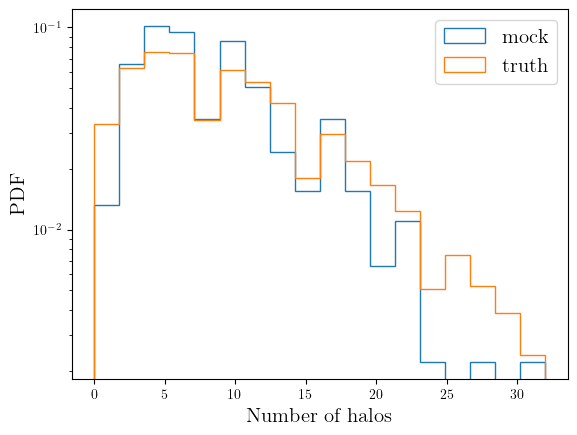

In [105]:
# Nhalo_all
# Nhalos_truth
pl.figure()
_ = pl.hist(Nhalo_all, bins=18, range=(0,32), density=True, histtype='step', label='mock')
_ = pl.hist(Nhalos_truth.flatten(), bins=18, range=(0,32), density=True, histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel('Number of halos', fontsize=15)
pl.ylabel('PDF', fontsize=15)



In [87]:
lgMsim_truth = dfhalo_ngp_wxyzM[:,:,:,:,3].flatten()
# select non-zero masses:
indpos = np.where(lgMsim_truth != 0.0)[0]
lgMsim_truth = lgMsim_truth[indpos]


Text(0, 0.5, 'PDF')

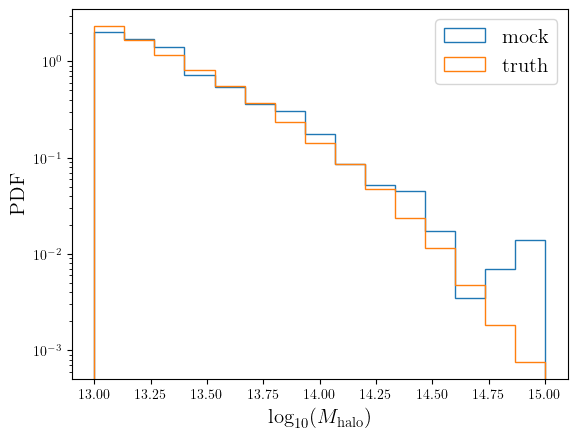

In [102]:
# Nhalo_all
pl.figure()
_ = pl.hist(Mhalo_all_concat, bins=15, range=(lgMin, 15), density=True, histtype='step', label='mock')
_ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)



In [154]:

# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# # print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))
# m.generate(context, max_new_tokens=160, nvox_samp=32)

source_batch = torch.LongTensor([
    [1, 2, 3, 0, 0, 0],
    [1, 2, 3, 4, 5, 6],
    [1, 2, 3, 4, 5, 0]
])

mask_batch = (source_batch != 0)



In [157]:
# mask_batch.unsqueeze(-1).shape


torch.Size([3, 6, 1])

In [182]:
# mask_batch.shape




In [190]:
# mask_batch_final.shape
# mask_batch_final[0,:,:] * float('-inf')
# put -inf values at mask==True positions:


In [192]:
# masked_logits
# mask_batch_final
# mask_batch_final = mask_batch_final.masked_fill(mask_batch_final == True, float('-inf'))


tensor([[[False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True]],

        [[False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False]],

        [[False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [ True,  True,  True,  True,  True,  True]]])

In [181]:
# mask_batch_final


tensor([[[False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True]],

        [[False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False]],

        [[False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [ True,  True,  True,  True,  True,  True]]])

In [ ]:
nMax_part = 150
dfpart_ngp_wxyzM = np.float32(np.zeros((grid, grid, grid, nMax_part, 4)))
# dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
# dfhalo_ngp_wy = np.float32(np.zeros((grid, grid, grid, nMax_h)))
# dfhalo_ngp_wz = np.float32(np.zeros((grid, grid, grid, nMax_h)))
# NGP_xyz(np.float32(pos_h_truth), dfhalo_ngp_wxyz_remainder, dfhalo_ngp_wxyz_factor, BoxSize)

NGP_xyzM(np.float32(pos_m_truth), np.float32(np.zeros(len(pos_m_truth))), dfpart_ngp_wxyzM, BoxSize)

dfpart_ngp_wxyz = dfpart_ngp_wxyzM[...,:3]


(0.0, 5.0)

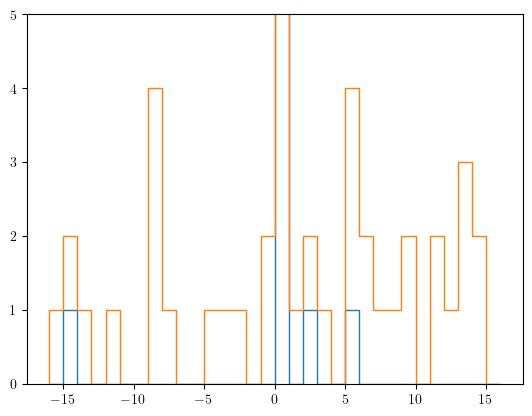

In [29]:
# dfhalo_ngp_wxyzM.shape, dfpart_ngp_wxyzM.shape
pl.figure()
_ = pl.hist(dfhalo_ngp_wxyzM[0,0,3,:,0].flatten(), bins=32, range=(-16, 16), histtype='step')
_ = pl.hist(dfpart_ngp_wxyz[0,0,3,:,0].flatten(), bins=32, range=(-16, 16), histtype='step')
# pl.scatter(dfhalo_ngp_wxyzM[0,0,0,:,0], dfpart_ngp_wxyz[0,0,0,:,0])
pl.ylim(0,5)


In [30]:
# np.amin(dfpart_ngp_wxyz), np.amax(dfpart_ngp_wxyz)
# dfhalo_ngp_wxyz.shape
lb_size = 15.625


(-15.625, 15.624875)

In [18]:
dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)

# M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)


In [19]:
Nhalos = np.float32(np.zeros((grid, grid, grid)))
MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)


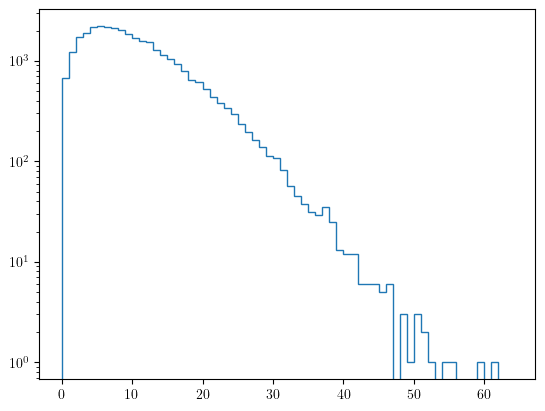

In [21]:
# np.amax(Nhalos)
pl.figure()
_ = pl.hist(Nhalos.flatten(), bins=64, range=(0, 64), histtype='step')
pl.yscale('log')



In [22]:
# np.argsort(dfhalo_ngp_wmass, axis=-1)
M_halos_argsort = np.flip(np.argsort(dfhalo_ngp_wmass, axis=-1), axis=-1)

# M_halos_argsort
# M_halos_argsort.shape, dfhalo_ngp_wxyz.shape
# dfhalo_ngp_xyz_sorted = dfhalo_ngp_wxyz[M_halos_argsort]
dfhalo_ngp_xyz_sorted = np.zeros_like(dfhalo_ngp_wxyz)
for i1 in range(grid):
    for i2 in range(grid):
        for i3 in range(grid):
            # for i4 in range(nMax_h):
            dfhalo_ngp_xyz_sorted[i1, i2, i3, :, 0] = dfhalo_ngp_wxyz[i1, i2, i3, M_halos_argsort[i1, i2, i3], 0]
            dfhalo_ngp_xyz_sorted[i1, i2, i3, :, 1] = dfhalo_ngp_wxyz[i1, i2, i3, M_halos_argsort[i1, i2, i3], 1]
            dfhalo_ngp_xyz_sorted[i1, i2, i3, :, 2] = dfhalo_ngp_wxyz[i1, i2, i3, M_halos_argsort[i1, i2, i3], 2]                        




In [326]:
# M_halos_argsort
pl.figure()



In [328]:
# # Nhalos_truth_recomb.shape
# indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo = np.unravel_index(np.argmax(Nhalos_truth_recomb, axis=None), Nhalos_truth_recomb.shape)

# # ind_max_Nhalo
# # indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo
# Nhalos_truth_recomb[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo]
# # dfhalo_ngp_wxyz_remainder[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo,:, 1]
# dfhalo_ngp_xyz_sorted[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo,:, 1]


In [329]:
root = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/fiducial_HR'
# # if snapnum > 0:
ptypes       = [1]
snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,isim_fid,snapnum,snapnum)
# df_ngp = MASL.density_field_gadget(snapshot, ptypes, 128, MAS='NGP',
#                                 do_RSD=False, axis=0, verbose=False)
# # df_ngp = MASL.density_field_gadget(snapshot, ptypes, 128, MAS='CIC',
# #                                 do_RSD=False, axis=0, verbose=False)
# # df_pylians_ngp_128 = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
# df_pylians_ngp_128 = df_ngp/np.mean(df_ngp, dtype=np.float64)



In [330]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], Nhalos.flatten()[::10], s=0.1)
# pl.scatter( Nhalos.flatten()[::10], df_pylians_ngp_128.flatten()[::10], s=0.1)
# pl.ylim(0, 20)

In [331]:
df_ngp = MASL.density_field_gadget(snapshot, ptypes, 512, MAS='NGP',
                                do_RSD=False, axis=0, verbose=False)
# df_ngp = MASL.density_field_gadget(snapshot, ptypes, 512, MAS='CIC',
                                # do_RSD=False, axis=0, verbose=False)
# df_pylians_ngp_512 = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
df_pylians_ngp_512 = df_ngp/np.mean(df_ngp, dtype=np.float64)     



In [332]:
# df_ngp = MASL.density_field_gadget(snapshot, ptypes, 1024, MAS='NGP',
#                                 do_RSD=False, axis=0, verbose=False)
# # df_ngp = MASL.density_field_gadget(snapshot, ptypes, 512, MAS='CIC',
#                                 # do_RSD=False, axis=0, verbose=False)
# # df_pylians_ngp_512 = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
# df_pylians_ngp_1024 = df_ngp/np.mean(df_ngp, dtype=np.float64)     



In [333]:
# df_ngp = MASL.density_field_gadget(snapshot, ptypes, 256, MAS='NGP',
#                                 do_RSD=False, axis=0, verbose=False)
# # df_ngp = MASL.density_field_gadget(snapshot, ptypes, 512, MAS='CIC',
#                                 # do_RSD=False, axis=0, verbose=False)
# # df_pylians_ngp_512 = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
# df_pylians_ngp_256 = df_ngp/np.mean(df_ngp, dtype=np.float64)     



In [334]:
# df_pylians_ngp_512_rs2 = np.reshape(df_pylians_ngp_512, (128,128,128,4,4,4))
# df_pylians_ngp_256_rs3 = np.reshape(df_pylians_ngp_256, (128,2,128,2,128,2))


In [335]:
df_pylians_ngp_512_rs3 = np.reshape(df_pylians_ngp_512, (128,4,128,4,128,4))


In [336]:
# df_pylians_ngp_1024_rs3 = np.reshape(df_pylians_ngp_1024, (128,8,128,8,128,8))



In [337]:
# # df_pylians_ngp_512_rs = np.reshape(df_pylians_ngp_512, (128,128,128,4,4,4))
# df_pylians_ngp_512_rs = np.zeros((128,128,128,4,4,4))

# for j1 in range(128):
#     for j2 in range(128):
#         for j3 in range(128):
#             df_pylians_ngp_512_rs[j1, j2, j3] = np.reshape(df_pylians_ngp_512[j1*4:(j1+1)*4, j2*4:(j2+1)*4, j3*4:(j3+1)*4], (4,4,4))


In [338]:
# df_pylians_ngp_512[j1*4:(j1+1)*4, j2*4:(j2+1)*4, j3*4:(j3+1)*4].shape


In [339]:
# df_pylians_ngp_512_rs_128 = np.mean(df_pylians_ngp_512_rs, axis=(3,4,5))



In [340]:
# df_pylians_ngp_512_rs2_128 = np.mean(df_pylians_ngp_512_rs2, axis=(3,4,5))



In [341]:
# df_pylians_ngp_256_rs3_128 = df_pylians_ngp_256_rs3.mean(5).mean(3).mean(1)



In [342]:
# df_pylians_ngp_512_rs3_128 = df_pylians_ngp_512_rs3.mean(5).mean(3).mean(1)


In [343]:
# df_pylians_ngp_1024_rs3_128 = df_pylians_ngp_1024_rs3.mean(5).mean(3).mean(1)



In [344]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_512_rs_128.flatten()[::10], Nhalos.flatten()[::10], s=0.1)
# # pl.scatter(Nhalos.flatten()[::10], df_pylians_ngp_512_rs3_128.flatten()[::10], s=0.1)
# pl.scatter(Nhalos.flatten()[::10], df_pylians_ngp_256_rs3_128.flatten()[::10], s=0.1)
# pl.ylim(0, 20)




In [345]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_512_rs_128.flatten()[::10], Nhalos.flatten()[::10], s=0.1)
# pl.scatter(Nhalos.flatten()[::10], df_pylians_ngp_1024_rs3_128.flatten()[::10], s=0.1)
# pl.ylim(0, 20)




In [346]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs_128.flatten()[::10], s=0.1)
# pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_256_rs3_128.flatten()[::10], s=0.1)
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs2_128.flatten()[::10], s=0.1)


In [347]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs_128.flatten()[::10], s=0.1)
# pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs3_128.flatten()[::10], s=0.1)
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs2_128.flatten()[::10], s=0.1)


In [348]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs_128.flatten()[::10], s=0.1)
# pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_1024_rs3_128.flatten()[::10], s=0.1)
# # pl.scatter(df_pylians_ngp_1024_rs3_128.flatten()[::10], df_pylians_ngp_512_rs3_128.flatten()[::10], s=0.1)
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs2_128.flatten()[::10], s=0.1)


In [349]:
# np.corrcoef(df_pylians_ngp_128.flatten(), df_pylians_ngp_256_rs3_128.flatten())
# np.corrcoef(df_pylians_ngp_128.flatten(), df_pylians_ngp_512_rs3_128.flatten())

# np.corrcoef(df_pylians_ngp_128.flatten(), df_pylians_ngp_1024_rs3_128.flatten())


In [350]:
# # dfhalo_ngp_wx.shape
# x_v, y_v, z_v = np.where(Nhalos==5)
# ind_v = 3
# print(Nhalos[x_v[ind_v], y_v[ind_v], z_v[ind_v]])

# dfhalo_ngp_xyz_sorted[x_v[ind_v], y_v[ind_v], z_v[ind_v], :,0]




In [351]:
# dfhalo_ngp_xyz_sorted[x_v[ind_v], y_v[ind_v], z_v[ind_v],:, 0]


In [352]:
# dfhalo_ngp_xyz_sorted.shape

In [353]:
# pl.figure()
# pl.scatter(dfhalo_ngp_xyz_sorted[x_v[ind_v], y_v[ind_v], z_v[ind_v],:, 0], dfhalo_ngp_xyz_sorted[x_v[ind_v], y_v[ind_v], z_v[ind_v],:, 1])
# pl.xlim(-4,4)
# pl.ylim(-4,4)


In [354]:
# pl.figure()
# # pl.imshow(np.sum(df_pylians_ngp_512_rs[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo,...], axis=-1), origin='lower')
# # pl.imshow(np.sum(df_pylians_ngp_512_rs[x_v[ind_v], y_v[ind_v], z_v[ind_v],...], axis=-1), origin='lower')
# pl.imshow(np.sum(df_pylians_ngp_512_rs3[x_v[ind_v],:, y_v[ind_v],:, z_v[ind_v],:], axis=-1), origin='lower')



In [355]:
# dfhalo_ngp_wxyz_factor[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo,:, 2]


In [356]:
# dfhalo_ngp_wy[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo,:]

dfhalo_ngp_xyz_sorted.shape


(128, 128, 128, 6, 3)

In [357]:
# 2.3%0.2
# saved = {'Nhalos_samp':Nhalos,
#          'Mhalos_samp':M_halos,
#          'Nhalos_truth':Nhalos_truth_recomb,
#          'Mhalos_truth':M_halos_truth_recomb,
#          'features_CNN':features_CNN_all}
# import pickle as pk
# savename = '/mnt/home/spandey/ceph/AR_NPE/notebooks/CMASS_TEST/data_for_GNN_LH3.pk'
# pk.dump(saved, open(savename, 'wb'))
saved = {'xyz_halos_truth_sub_box':dfhalo_ngp_xyz_sorted,
        'hres_rho_dm':df_pylians_ngp_512_rs3.reshape(grid,grid,grid,64),
        # 'Nhalos_samp':Nhalos,
        #  'Mhalos_samp':M_halos,
         'Nhalos_truth':Nhalos_truth_recomb,
         'Mhalos_truth':M_halos_truth_recomb,
         'features_CNN':features_CNN_all}
        
# 'xyz_halos_truth_sub_box':dfhalo_ngp_wxyz_remainder,
        #  'Nhalos_truth':Nhalos_truth_recomb,
        #  'Mhalos_truth':M_halos_truth_recomb,
        #  'features_CNN':features_CNN_all}
import pickle as pk
savename = f'/mnt/home/spandey/ceph/AR_NPE/notebooks/CMASS_TEST/test_xyz/data_for_MDN_fidHR_{isim_fid}.pk'
pk.dump(saved, open(savename, 'wb'))


In [228]:
dfhalo_ngp_wxyz_remainder.shape



(128, 128, 128, 8, 3)

In [114]:
M_halos_truth_recomb.shape



(128, 128, 128, 8)

In [30]:
import numpy as np

ntry = 100000
nsamp = 100
mu_try, sig_try = np.zeros(ntry), np.zeros(ntry)
var_try = np.zeros(ntry)
for ji in range(ntry):
    s1 = np.random.randn(nsamp)
    mu_try[ji], sig_try[ji] = np.mean(s1), np.std(s1)
    var_try[ji] = np.var(s1)



In [15]:
# np.mean(s1), np.std(s1)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl


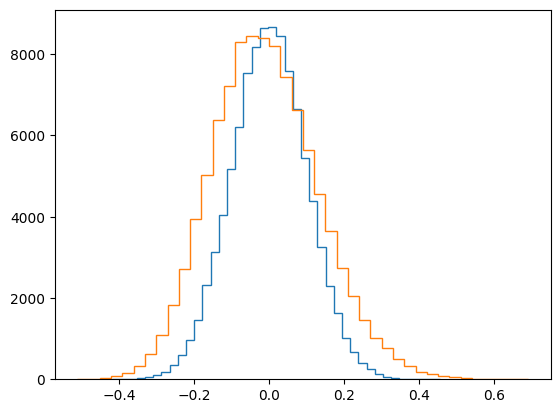

In [31]:
pl.figure()
_ = pl.hist(mu_try, bins=40, histtype='step')
_ = pl.hist(var_try-1., bins=40, histtype='step')
# _ = pl.hist(sig_try-1, bins=40, histtype='step')

In [32]:
np.mean(mu_try), np.std(mu_try)


(-0.0003129160749577889, 0.09996861854525756)

In [29]:
np.mean(sig_try), np.std(sig_try)



(0.9924234829102101, 0.07075275052368166)

In [33]:
np.mean(var_try), np.std(var_try)



(0.9902667524601717, 0.1410539189370056)